<a href="https://colab.research.google.com/github/LUMII-AILab/NLP_Course/blob/main/notebooks/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **NER**: Nosaukto entitāšu marķēšana | Named Entity Recognition

## Flair

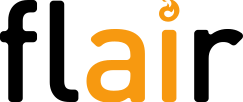

Flair allows to apply state-of-the-art natural language processing (NLP) models to text, such as named entity recognition (NER), sentiment analysis, part-of-speech tagging (PoS), etc. More info: https://github.com/flairNLP/flair

### Setting up the environment

In [ ]:
!pip install flair

In [ ]:
from flair.data import Sentence
from flair.nn import Classifier
from flair.data import Corpus
from flair.trainers import ModelTrainer
from flair.models import SequenceTagger
from flair.datasets import ColumnCorpus
from flair.embeddings import TokenEmbeddings, WordEmbeddings, StackedEmbeddings, PooledFlairEmbeddings
from typing import List

___
NER tagging

In [ ]:
def ner_tag(sentence, model='ner'):
    # make a sentence
    sentence = Sentence(sentence)

    # load the NER tagger
    tagger = Classifier.load(model)

    # run NER over sentence
    tagger.predict(sentence)

    return sentence

In [ ]:
example = "George Washington was the first president of the United States of America."
sentence = ner_tag(example)
# print the sentence with all annotations
print(sentence)

In [ ]:
for entity in sentence.get_spans('ner'):
    print(entity)

___
**Different NER models offered by Flair**
___
Standard Flair NER model offers 4 classes:
* PER (person),
* ORG (organization),
* LOC (location),
* MISC (miscellanious)


Alternatively the 'ner-ontonotes-large' offers 18 seperate classes.

In [ ]:
sentence = 'On September 1st George won 1 dollar while watching Game of Thrones.'

# Standard Flair NER model offer
ner_tag(sentence)
# Expanded NER model
ner_tag(sentence, 'ner-ontonotes-large')

### Training a custom Flair NER model


Example of code for training English NER model: https://github.com/flairNLP/flair/blob/master/resources/docs/EXPERIMENTS.md

In [ ]:
!git clone https://github.com/flairNLP/CleanCoNLL.git

In [ ]:
%cd CleanCoNLL/
!chmod u+x create_cleanconll_from_conll03.sh
!SCRIPT_ROOT=. bash create_cleanconll_from_conll03.sh
%cd ..

In [ ]:
# # define columns
columns = {0 : 'text', 1 : 'pos', 2 : 'wiki', 3 : 'ner', 4 : 'ner_old'}

# # directory where the data resides
data_folder = 'CleanCoNLL/data/cleanconll/'

# initializing the corpus
corpus: Corpus = ColumnCorpus(data_folder, columns,
                              train_file='cleanconll.train',
                              test_file='cleanconll.test',
                              dev_file='cleanconll.dev')

In [ ]:
# tag to predict
tag_type = 'ner'

# make tag dictionary from the corpus
tag_dictionary = corpus.make_label_dictionary(label_type=tag_type)

In [ ]:
# initialize embeddings
embedding_types: List[TokenEmbeddings] = [

    # GloVe embeddings
    WordEmbeddings('glove'),

    # contextual string embeddings, forward
    PooledFlairEmbeddings('news-forward', pooling='min'),

    # contextual string embeddings, backward
    PooledFlairEmbeddings('news-backward', pooling='min'),
]


embeddings : StackedEmbeddings = StackedEmbeddings(embeddings=embedding_types)

tagger : SequenceTagger = SequenceTagger(hidden_size=256,
                                       embeddings=embeddings,
                                       tag_dictionary=tag_dictionary,
                                       tag_type=tag_type,
                                       use_crf=True)
print(tagger)

In [ ]:
trainer: ModelTrainer = ModelTrainer(tagger, corpus)

trainer.train('resources/taggers/example-ner',
              train_with_dev=True,
              max_epochs=10)

In [ ]:
# load the trained model
model = SequenceTagger.load('resources/taggers/example-ner/final-model.pt')

# create example sentence
sentence = Sentence('I love Berlin')

# predict the tags
model.predict(sentence)

print(sentence.to_tagged_string())

## LV-PIPE API: NER latviešu valodas tekstam | NER for Latvian

In [ ]:
import requests
import urllib
import json

text_lv = "Ģertrūdes ielas teātris aicina uz Baltijas neatkarīgo teātru viesizrādēm, kas notiks 3. aprīlī."


# Calls the LV-PIPE REST API
def process_lvpipe(text, steps=None, api_url="https://nlp.ailab.lv/api/nlp"):
    steps = steps or ['tokenizer', 'morpho', 'parser', 'ner']

    response = requests.post(api_url, json={'data': {'text': text}, 'steps': steps})
    return response.json()['data']


doc = process_lvpipe(text_lv)

with open("lvpipe_output.json", 'w') as f:
    json.dump(doc, f, indent=4, ensure_ascii=False)

with open("lvpipe_output.json", 'r') as f:
    print(f.read())

In [ ]:
with open("lvpipe_output.json", encoding="utf-8") as j_file:
    data = json.load(j_file)
    sents = data["sentences"]
    for sent in sents:
        if sent["ner"]:
            for ner in sent["ner"]:
                print(ner)